In [1]:
import numpy as np 

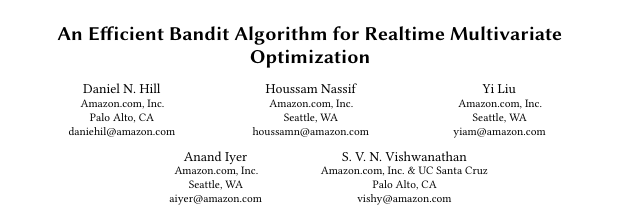

This notebook implements a simulation for the model described in *An Efficient Bandit Algorithm for Realtime Multivariate Optimization*
by Hill et al.

* For a website with $D$ widgets, let $n_i , i \in \lbrace 1, 2, ..., D \rbrace$ denote the number of variations for widget $i$ \
  *NOTE: Code is zero-indexed*


In [2]:
n = (3, 3, 3)
print(f'Widget 1 has {n[0]} variations')

Widget 1 has 3 variations


* Denote layout $A \in \Pi_{i=1}^D \lbrace 1, 2, ..., n_i \rbrace$ 

In [3]:
class Layout:
    def __init__(self, A):
        self.A = A
        self.ohe = self._get_ohe()
            
    def __repr__(self):
        result = 'Layout:'
        for i, c in enumerate(self.A):
            result += f'\n  Widget {i+1}: variation {c+1}'
        return result
    
    def _get_ohe(self):
        result = np.zeros(sum(n))
        start = 0
        for i, c in enumerate(self.A):
            result[start + c] = 1
            start += n[i]
        
        return result.reshape(1, -1)

layout = Layout([0, 2, 1])
layout

Layout:
  Widget 1: variation 1
  Widget 2: variation 3
  Widget 3: variation 2

* Context $X \sim F_\theta $ has features that may influence the reward.
* $X$ and $A$ are combined to form $B_{A,X}\in \mathbb{R}^M$ to model interactions between context and website lay-out
* Simulate reward with linear model:
  $$
  \begin{align}
  \mathbb{P}(R|A,X) &= \Phi(R * B_{A,X}^{\intercal}W) \\
  B_{A,X}^{\intercal}W 
      &= \frac{1}{\beta}[W^0 + \alpha_1 \sum_{i=1}^D W_i^1(A) \\
      &+ \alpha_2 \sum_{j=1}^D \sum_{k=j+1}^D W_{j,k}^2(A) \\
      &+ \alpha_c \sum_{l=1}^L W_l^c(X) 
          + \alpha_c \sum_{m=1}^D \sum_{n=1}^L W_{m,n}^{1c}(A,X)
  \end{align}
  $$
  

In [4]:
β = 5
α_1 = 1
α_2 = 2
α_c = 0

In [5]:
W_0 = np.random.normal(size=1)
W_1 = np.random.normal(size=sum(n)).reshape(1, -1)
W_2 = np.random.normal(size=(sum(n), sum(n)))

* Let ohe context vector be L dimensional

In [6]:
L = 5
A = np.random.randint(low=0, high=2, size=L).reshape(1, -1)

In [7]:
W_c = np.random.normal(size=L) # first-order context interaction weights
W_1c = np.random.normal(size=(L, sum(n))) # first-order context-widget interaction weights

In [8]:
# Boolean matrix for 1st order context-widget interactions
(A.T * layout.ohe)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
# Boolean matrix for 2nd order widget-widget interactions
layout.ohe.T @ layout.ohe

array([[1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
res = β **-1 * (
    W_0
    + α_1 * np.sum(W_1 * layout.ohe)
    + α_2 * np.sum(W_2 * (layout.ohe.T @ layout.ohe))
    + α_c * np.sum(W_c * A)
    + α_c * np.sum(W_1c * (A.T @ layout.ohe))
)
res

array([-0.98638213])

In [11]:
from scipy.stats import norm

In [12]:
n = (8, 8, 8)

In [13]:
W_0 = np.random.normal()
W_1 = np.random.normal(size=sum(n)).reshape(1, -1)
W_2 = np.random.normal(size=(sum(n), sum(n)))
W_c = np.random.normal(size=L)
W_1c = np.random.normal(size=(L, sum(n)))

In [14]:
import itertools 

layouts = [
    Layout(A=[i, j, k]) for (i, j, k) in itertools.product(*[
        list(range(n_i)) for n_i in n
    ])
]

In [15]:
base_p = np.array([
    np.sum(
        W_0
        + α_1 * np.sum(W_1 * layout.ohe)
        + α_2 * np.sum(W_2 * (layout.ohe.T @ layout.ohe))
        + α_c * np.sum(W_c * A)
        + α_c * np.sum(W_1c * (A.T @ layout.ohe))
    )
    for layout in layouts
])

In [16]:
import scipy.optimize

In [17]:
desired_var = 0.002
res = scipy.optimize.root_scalar(
    f = lambda β: np.var(norm.cdf((1 / β) * base_p)) - desired_var,
    x0 = 1,
    x1 = 10
)
print(res)
β = res.root

      converged: True
           flag: 'converged'
 function_calls: 15
     iterations: 14
           root: 51.27156391183501


In [ ]:
result = []

for _ in range(500):
    # Sample a random context
    A = np.random.randint(low=0, high=2, size=L).reshape(1, -1)
    
    # Compute click probabilities 
    p = norm.cdf((1 / β) * np.array([
        np.sum(
            W_0
            + α_1 * np.sum(W_1 * layout.ohe)
            + α_2 * np.sum(W_2 * (layout.ohe.T @ layout.ohe))
            + α_c * np.sum(W_c * A)
            + α_c * np.sum(W_1c * (A.T @ layout.ohe))
        )
        for layout in layouts
    ]))
    
    result += list(p)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig = sns.histplot(result, bins=45)
fig.set_xlim(0.3, 0.8)
fig.set_ylabel('occurences')
fig.set_xlabel('success probability')